In [32]:
import h5py
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np

FONTS = ['Skylark', 'Ubuntu Mono', 'Sweet Puppy']

file_name = "font_recognition_train_set/SynthText.h5"

db = h5py.File(file_name, "r")
im_names = list(db["data"].keys())

num_of_images = len(im_names)

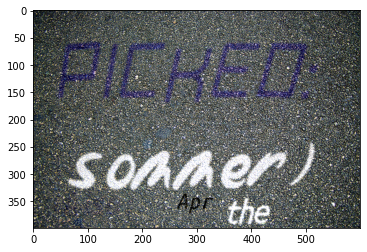

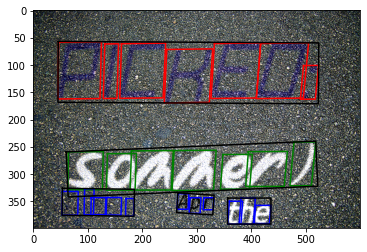

In [40]:
i = 12

img_name = im_names[i]
img = db['data'][img_name][:]
font = db['data'][img_name].attrs['font']
txt = db['data'][img_name].attrs['txt']
charBB = db['data'][img_name].attrs['charBB']
wordBB = db['data'][img_name].attrs['wordBB']

nC = charBB.shape[-1]
plt.imshow(img)

img_copy = img.copy()

plt.figure()
plt.imshow(img_copy)

for b_inx in range(nC):
    if (font[b_inx].decode('UTF-8') == FONTS[0]):
        color = 'r'
    elif (font[b_inx].decode('UTF-8') == FONTS[1]):
        color = 'b'
    else:
        color = 'g'
    bb = charBB[:, :, b_inx]
    x = np.append(bb[0, :], bb[0, 0])
    y = np.append(bb[1, :], bb[1, 0])
    plt.plot(x, y, color)
nW = wordBB.shape[-1]
for b_inx in range(nW):
    bb = wordBB[:, :, b_inx]
    x = np.append(bb[0, :], bb[0, 0])
    y = np.append(bb[1, :], bb[1, 0])
    plt.plot(x, y, 'k')


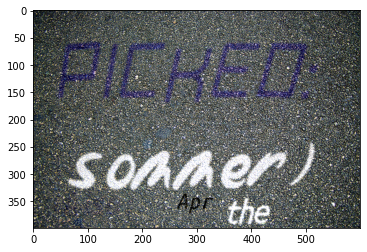

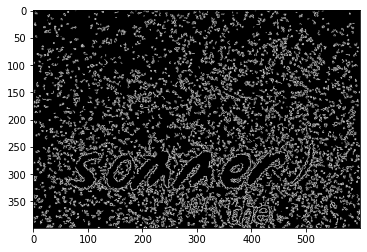

In [36]:
edges = cv.Canny(img, 350, 700)

plt.imshow(img)
plt.show()

plt.imshow(edges, cmap='gray')
plt.show()